In [353]:
import datetime
import json
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt

## Data Acquisition

### API Access
The code below calls two different APIs to access Wikimedia data.

In [354]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [355]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters))
    response = call.json()['items']
    
    return response

### Define parameters
We create five different dictionaries with the specific parameters for the API calls.


In [356]:
#Parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
pagecounts_desktop_site_200801_202008 = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2020080100"
                    }

pagecounts_mobile_site_200801_202008 = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2020080100"
                    }

# Parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
pageviews_desktop_200801_202008 = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20080101",
                    # for end use 1st day of month following final month of data
                    "end" : '20200801'
                        }

pageviews_mobile_app_200801_202008 = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20080101",
                    # for end use 1st day of month following final month of data
                    "end" : '20200801'
                        }

pageviews_mobile_web_200801_202008 = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '20200801'
                        }

### API Calls
Next, we will use the api_call function to call 5 different data sources:
- pagecounts desktop
- pagecounts mobile
- pageviews desktop
- pageviews mobile app
- pageview mobile web

In [357]:
# Legacy API
pagecounts_desktop_site_200801_202008_json = api_call(endpoint_legacy, pagecounts_desktop_site_200801_202008)
pagecounts_mobile_site_200801_202008_json = api_call(endpoint_legacy, pagecounts_mobile_site_200801_202008)

# Pageview API
pageviews_desktop_200801_202008_json = api_call(endpoint_pageviews, pageviews_desktop_200801_202008)
pageviews_mobile_app_200801_202008_json = api_call(endpoint_pageviews, pageviews_mobile_app_200801_202008)
pageviews_mobile_web_200801_202008_json = api_call(endpoint_pageviews, pageviews_mobile_web_200801_202008)

### Save to JSON files

We then save each object into a json file. 

In [358]:
# list of tuples with object and filename to be saved
api_objects = [(pagecounts_desktop_site_200801_202008_json,'pagecounts_desktop-site_200801-202008.json'),
               (pagecounts_mobile_site_200801_202008_json,'pagecounts_mobile-site_200801-202008.json'),
               (pageviews_desktop_200801_202008_json,'pageviews_desktop-site_200801-202008.json'),
               (pageviews_mobile_app_200801_202008_json,'pageviews_mobile-app_200801_202008.json'),
               (pageviews_mobile_web_200801_202008_json, 'pageviews_mobile-web_200801_202008.json')]


#Save JSON files to current directory
for api_obj in api_objects:
    file_name = api_obj[1]
    obj = api_obj[0]
    with open(file_name, 'w') as outfile:
        json.dump(obj, outfile)
   

## Data Preparation

The code below has two objectives:
### 1. Create a dataframe with all types of access
We first collected the five different types of access.
Now we will combine all of this data by doing a for loop over all our datasets and concatenating them. 

### 2. Combine Pageviews mobile-app and mobile-web data
In the new API you can differentiate people that access Wikipedia via their mobile phones by using an app or by using a website. 
We want to treat both as being access via mobile (without differentiation). 
We do this by creating a column called type in which we name the source (pagecounts vs pageviews) and the access (desktop vs mobile) by following the file string format we created prior. 

In [359]:
all_views = pd.DataFrame()
for obj in api_objects: #for loop over our files and filenames
    temp_df = pd.DataFrame(obj[0])
    temp_df['type'] = obj[1].split("-")[0] + "_view" #creating type
    if all_views.empty:
        all_views = temp_df     
    else:
        all_views = pd.concat([all_views, temp_df])
        
all_views

,project,access-site,granularity,timestamp,count,type,access,agent,views
0,en.wikipedia,desktop-site,monthly,2008010100,4.930903e+09,pagecounts_desktop_view,NaN,NaN,NaN
1,en.wikipedia,desktop-site,monthly,2008020100,4.818394e+09,pagecounts_desktop_view,NaN,NaN,NaN
2,en.wikipedia,desktop-site,monthly,2008030100,4.955406e+09,pagecounts_desktop_view,NaN,NaN,NaN
3,en.wikipedia,desktop-site,monthly,2008040100,5.159162e+09,pagecounts_desktop_view,NaN,NaN,NaN
4,en.wikipedia,desktop-site,monthly,2008050100,5.584691e+09,pagecounts_desktop_view,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
56,en.wikipedia,NaN,monthly,2020030100,NaN,pageviews_mobile_view,mobile-web,user,4.537281e+09
57,en.wikipedia,NaN,monthly,2020040100,NaN,pageviews_mobile_view,mobile-web,user,5.332822e+09
58,en.wikipedia,NaN,monthly,2020050100,NaN,pageviews_mobile_view,mobile-web,user,5.089055e+09
59,en.wikipedia,NaN,monthly,2020060100,NaN,pageviews_mobile_view,mobile-web,user,4.552042e+09


### Reshaping and cleaning the data
- We will group our data based on timestamp and the type we created.
- We will combine views and counts, as they mean the same (accesses to Wikipedia) but from different APIs.
- Then we will pivot our data in order to show per timestamp the views per type + access of API.
- Finally, we substitute NaNs (no usage exists) for zeros (zero usage) in our data. 

In [360]:
all_views = all_views.groupby(['timestamp', 'type']).sum().reset_index()
all_views['total'] = all_views['views'] + all_views['count']
all_views = all_views.pivot(index='timestamp', columns='type', values='total').reset_index().fillna(0)

all_views

type,timestamp,pagecounts_desktop_view,pagecounts_mobile_view,pageviews_desktop_view,pageviews_mobile_view
0,2008010100,4.930903e+09,0.0,0.000000e+00,0.000000e+00
1,2008020100,4.818394e+09,0.0,0.000000e+00,0.000000e+00
2,2008030100,4.955406e+09,0.0,0.000000e+00,0.000000e+00
3,2008040100,5.159162e+09,0.0,0.000000e+00,0.000000e+00
4,2008050100,5.584691e+09,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...
146,2020030100,0.000000e+00,0.0,3.412498e+09,4.686271e+09
147,2020040100,0.000000e+00,0.0,3.798373e+09,5.505742e+09
148,2020050100,0.000000e+00,0.0,3.078094e+09,5.231700e+09
149,2020060100,0.000000e+00,0.0,2.721329e+09,4.573975e+09


In this section, we create new columns with the total views per API (pagecounts and pageviews).
We also created some Date columns (year, month).
And we limited the columns and the order we are displaying them.

In [361]:
# Columns with totals per API
all_views['pagecounts_all_view'] =all_views['pagecounts_desktop_view'] + all_views['pagecounts_mobile_view']
all_views['pageviews_all_view'] =all_views['pageviews_desktop_view'] + all_views['pageviews_mobile_view']

# Columns with Date values (year, month)
all_views.index = pd.to_datetime(all_views.timestamp,  format='%Y%m%d%f')
all_views['year'] = pd.DatetimeIndex(all_views.index).year
all_views['month'] = pd.DatetimeIndex(all_views.index).month

# Selecting columns and cleaning names
all_views = all_views[['year', 'month', 'pagecounts_all_view', 'pagecounts_desktop_view', 'pagecounts_mobile_view', 
                   'pageviews_all_view', 'pageviews_desktop_view', 'pageviews_mobile_view']]
all_views.columns.name =''
all_views

,year,month,pagecounts_all_view,pagecounts_desktop_view,pagecounts_mobile_view,pageviews_all_view,pageviews_desktop_view,pageviews_mobile_view
timestamp,,,,,,,,
2008-01-01,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-02-01,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-03-01,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-04-01,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-05-01,2008,5,5.584691e+09,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
2020-03-01,2020,3,0.000000e+00,0.000000e+00,0.0,8.098769e+09,3.412498e+09,4.686271e+09
2020-04-01,2020,4,0.000000e+00,0.000000e+00,0.0,9.304115e+09,3.798373e+09,5.505742e+09
2020-05-01,2020,5,0.000000e+00,0.000000e+00,0.0,8.309794e+09,3.078094e+09,5.231700e+09


### Saving to CSV file

In [362]:
all_views.to_csv("en-wikipedia_traffic_200801-202008.csv")

## Create Visualization

We replaced zeros for NaNs in our dataset for aesthetics reasons (we don't want to plot a sequence of zeros).
We then proceed to using Matplolib plot to plot 6 line graphs. 

We saved the final result to a JPEG file. 

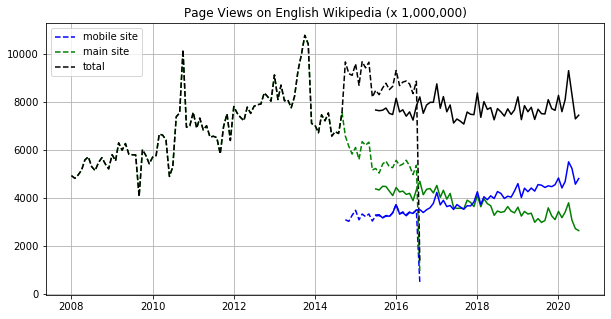

In [371]:
all_views2 = all_views.replace(0, np.nan)

# Create lines
plt.plot(all_views2.index,all_views2['pagecounts_mobile_view']/1000000,  linestyle='dashed', color='blue', label='mobile site')
plt.plot(all_views2.index,all_views2['pagecounts_desktop_view']/1000000, linestyle='dashed', color='green', label='main site')
plt.plot(all_views2.index, all_views2['pagecounts_all_view']/1000000, linestyle='dashed', color='black', label='total')
plt.plot(all_views2.index, all_views2['pageviews_all_view']/1000000, color='black')
plt.plot(all_views2.index, all_views2['pageviews_desktop_view']/1000000, color='green')
plt.plot(all_views2.index, all_views2['pageviews_mobile_view']/1000000, color='blue')

#Other aspects 
plt.rcParams["figure.figsize"] = (10,5) 
plt.legend(loc="upper left") 
plt.title("Page Views on English Wikipedia (x 1,000,000)")
plt.grid()
#plt.text( 0.005, 0.005, "testing",  horizontalalignment='center')

#save figure
plt.gcf() # get current figure - helps with savefig
plt.savefig('image.jpg')

plt.show()

In [374]:
all_views


,year,month,pagecounts_all_view,pagecounts_desktop_view,pagecounts_mobile_view,pageviews_all_view,pageviews_desktop_view,pageviews_mobile_view
timestamp,,,,,,,,
2008-01-01,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-02-01,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-03-01,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-04-01,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2008-05-01,2008,5,5.584691e+09,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
2020-03-01,2020,3,0.000000e+00,0.000000e+00,0.0,8.098769e+09,3.412498e+09,4.686271e+09
2020-04-01,2020,4,0.000000e+00,0.000000e+00,0.0,9.304115e+09,3.798373e+09,5.505742e+09
2020-05-01,2020,5,0.000000e+00,0.000000e+00,0.0,8.309794e+09,3.078094e+09,5.231700e+09


In [377]:
for col in all_views.columns:
    print(type(all_views[col][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
